# **TensorFlow - Help Protect the Great Barrier Reef**
### **Detect crown-of-thorns starfish in underwater image data**

### In this competition, you will predict the presence and position of crown-of-thorns starfish in sequences of underwater images taken at various times and locations around the Great Barrier Reef. Predictions take the form of a bounding box together with a confidence score for each identified starfish. An image may contain zero or more starfish

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
import tensorflow as tf
# For drawing onto image
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
# For measuring reference time
import time
print(tf.__version__)

2.8.0


### **Get data from google drive**

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cots_train_images_100.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cots_test_images.zip","r")
zip_ref.extractall("/content/")
zip_ref.close()

#### **Upload cots_train_100.xlsx & test.csv from F:\KAGGLE**

In [ ]:
excel_file = pd.read_excel("/content/cots_train_100.xlsx")  #converting excel to csv
excel_file.to_csv("cots_train_100.csv", index=False, header=True)

In [ ]:
train_dir = "/content/cots_train_images_100"  # training folder
test_dir = "/content/cots_test_images"        # testing folder
train_path = "/content/cots_train_100.csv"

In [ ]:
train_df = pd.read_csv(train_path)

In [ ]:
train_df.shape

(200, 6)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        200 non-null    int64 
 1   sequence        200 non-null    int64 
 2   video_frame     200 non-null    int64 
 3   sequence_frame  200 non-null    int64 
 4   image_id        200 non-null    object
 5   annotations     200 non-null    object
dtypes: int64(4), object(2)
memory usage: 9.5+ KB


In [ ]:
# for dirpath, dirnames, filenames in os.walk("cots_train_images_100"):
#   print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

In [ ]:
# for dirpath, dirnames, filenames in os.walk("cots_test_images"):
#   print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

#### **Let's view the images**

In [ ]:
def view_random_image(video_path):
    """
    created on: 24th December, 2021 Friday
    argument: directory path of a specific video
    plots a random image from specified video
    """
    # select a random image
    random_img = random.choice(os.listdir(video_path))
    # get the path of that image
    image_path = os.path.join(video_path, random_img)
    # read the image
    image = img.imread(image_path)
    # plot the image
    plt.imshow(image)
    
    print(image.shape, image_path)

In [ ]:
# view_random_image("cots_train_images_100/v0")

In [ ]:
# view_random_image("cots_train_images_100/v1")

In [ ]:
# view_random_image("cots_train_images_100/v2")

### NOTE: Here they have given annotations in the form: **(x_min, y_min, width, height)** where x_min & y_min are top left corner co-ordinates.
#### Usaually two annotations are used for bounding boxes:

> 1.**(upper-left, lower-right)** ie. (x_min, y_min, x_max, y_max) where x_min, y_min are top left corner coordinates and x_max, y_max are bottom right coordinates.

> 2.**(center, width, height)** ie. (c_x, c_y, width, height)

#### I am converting the annotations to (upper-left, lower-right) format.

In [ ]:
# video_{video_id}/{video_frame_number}.jpg
def get_image_info(df):
    """
    created on: 27th December, 2021 Monday
    argument: video specific dataframe (eg. video0_df, video1_df, video2_df)
    This method returns a list of image paths & bounding boxes for COTS in the image.
    """
    path_list = []
    box = []
    boxes = dict()
    a = 1
    for i in range(len(df)):
        # print("Index: ",i)
        s = df['annotations'][i]
        # print(s)
        if s != "[]":
            count = s.count("{")

            if count>1:      # if there are more than one crown of thorns star fish in the image
                s = s.strip("[]")
#                 print(s)
                s = s.strip("{}")
#                 print(s)
                s = s.split("},")
#                 print(s, len(s))
                for j in range(len(s)):        
                    xmin = int(s[j].split(",")[0].strip("{\'x\': "))
                    ymin = int(s[j].split(",")[1].strip("\'y\': "))
                    width = int(s[j].split(",")[2].strip("\'width\': "))
                    height = int(s[j].split(",")[3].strip("\'height\': "))
                    xmax = xmin + width
                    ymax = ymin + height
#                     a = (xmin+ymin+xmax+ymax)
                    box.append([xmin, ymin, xmax, ymax])
#                     print("Index: ",i)
#                     print(xmin, ymin, xmax, ymax, width, height)
            else:
                s = s.strip("[{}]")    
                xmin = int(s.split(",")[0].strip("\'x\': "))
                ymin = int(s.split(",")[1].strip("\'y\': "))
                width = int(s.split(",")[2].strip("\'width\': "))
                height = int(s.split(",")[3].strip("\'height\': "))
                xmax = xmin + width
                ymax = ymin + height
                box.append([xmin, ymin, xmax, ymax])
#                 print(xmin, ymin, xmax, ymax, width, height)
        boxes[i]=box
        box = []
        image_path = os.path.join(train_dir,"v"+str(df.iloc[i]['video_id'])+"/"+str(df.iloc[i]['video_frame'])+".jpg")
        path_list.append(image_path)
        image_path = ""
    return path_list, boxes

In [ ]:
image_paths_list, boxes = get_image_info(train_df)

In [ ]:
# image_paths_list[0:2]

In [ ]:
type(boxes), boxes[130], image_paths_list[130].split("/")[4].split(".")

(dict, [[609, 0, 739, 62]], ['611', 'jpg'])

In [ ]:
def display_bbox(img_idx, boxes, image_paths_list):
  img = Image.open(image_paths_list[img_idx])
  # print(len(boxes[img_idx]))
  img1 = ImageDraw.Draw(img)
  for i in range(len(boxes[img_idx])):
    left, right, top, bottom = boxes[img_idx][i][0], boxes[img_idx][i][2], boxes[img_idx][i][1], boxes[img_idx][i][3]
    img1.line([(left, top), (left, bottom), (right, bottom), (right, top),
              (left, top)], width=5, fill="red")
  # uncomment following 3 lines to save the annotated image
  # video_folder = image_paths_list[img_idx].split("/")[3]
  # img_name = image_paths_list[img_idx].split("/")[4].split(".")[0]
  # img = img.save(f"/content/annotated_images/{video_folder}/{img_name}.jpg", format="jpeg") # save the annotated image
  return img

In [ ]:
# img_idx = 50
# img = display_bbox(img_idx, boxes, image_paths_list)
# img

In [ ]:
path = "/content/cots_train_images_100"
v0_path = os.path.join(path, "v0") # /content/cots_train_images_100/v0
v1_path = os.path.join(path, "v1")
v2_path = os.path.join(path, "v2")

# Create annotated images

In [ ]:
# img_idx = 151  # start index for v0: 1, start index for v1: 101
# for i in os.listdir(v2_path):
#   if img_idx<len(image_paths_list):
#       display_bbox(img_idx, boxes, image_paths_list)
#       img_idx = img_idx + 1
#   else:
#     break


# !zip -r /content/file.zip /content/annotated_images

# from google.colab import files
# files.download("/content/file.zip")

In [ ]:
# !pip install d2l==0.17.1
# !pip install -U mxnet-cu101==1.7.0

In [ ]:
# type(boxes), len(boxes), type(boxes[50]), boxes[50]

# Preprocessing the images
> Normalizing the bounding boxes

> flipping the images & bouding boxes from left to right

> resizing/rescaling images

In [ ]:
def normalize_bboxes(bboxes):
  """ This method normalizes the bounding box co-ordinates & returns the same """

  norm_bboxes = {key:None for key in bboxes.keys()}  # create an empty dictionary with only keys

  for i in range(len(bboxes)):
    if bboxes[i]== []:                               # if there are no COTS in an image, its bb coodinates will be empty
      norm_bboxes[i]= []
    else:                                            # if there are multiple COTS in an image, use tf.keras.utils.normalize() to normalize the co-ordinates
      norm_bboxes[i] = [] 
      for j in bboxes[i]:  
        norm_bboxes[i].append(tf.keras.utils.normalize(j).squeeze())

  return norm_bboxes

In [ ]:
norm_box = normalize_bboxes(boxes)

In [ ]:
norm_box[50][0] # dict=>list=>array

numpy.ndarray

## Assigning class ids
> 0: No COTS present in the image

> 1: for a starfish present in the image

In [ ]:
# train_df.drop("class_id",axis=1, inplace=True)
train_df["class_id"] = ""

In [ ]:
for i in range(len(norm_box)):
  train_df["class_id"][i] = []
  if norm_box[i]==[]:
    train_df["class_id"][i].append(0)           # No COTS present in image
  else:
    for j in range(len(norm_box[i])):
      train_df["class_id"][i].append(1)       # 1 or more COTS present in image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,class_id
0,0,40258,0,0,0-0,[],[0]
1,0,40258,1,1,0-1,[],[0]
2,0,40258,2,2,0-2,[],[0]
3,0,40258,3,3,0-3,[],[0]
4,0,40258,4,4,0-4,[],[0]
...,...,...,...,...,...,...,...
195,2,22643,5379,16,2-5379,"[{'x': 207, 'y': 139, 'width': 35, 'height': 4...","[1, 1]"
196,2,22643,5380,17,2-5380,"[{'x': 200, 'y': 127, 'width': 35, 'height': 4...","[1, 1]"
197,2,22643,5381,18,2-5381,"[{'x': 192, 'y': 116, 'width': 35, 'height': 4...","[1, 1]"
198,2,22643,5382,19,2-5382,"[{'x': 189, 'y': 98, 'width': 35, 'height': 43...","[1, 1]"


In [ ]:
def random_flip_images(image, boxes):
  """ This method flips an image and corresponding bounding box """
  # if tf.random.uniform(())>0.5:
  new_image = tf.image.flip_left_right(image)
  new_box = tf.stack(boxes, axis=1)
  return new_image, new_box

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [ ]:
# type(norm_box), len(norm_box), type(norm_box[50]), len(norm_box[50]), norm_box[130]

In [ ]:
import matplotlib.image as img

In [ ]:
# ann_img = Image.open("/content/annotated_images/v0/50.jpg")
# ann_img

(720, 1280, 3) cots_train_images_100/v0/77.jpg


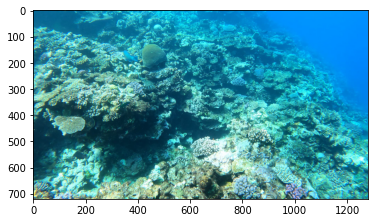

In [ ]:
random_img = random.choice(os.listdir("cots_train_images_100/v0"))
image = img.imread(os.path.join("cots_train_images_100/v0", random_img))
plt.imshow(image)
print(image.shape, os.path.join("cots_train_images_100/v0", random_img))

In [ ]:
type(random_img), int(random_img.split(".")[0])  # get file name to index into the bounding box

(str, 77)

In [ ]:
new_image , new_box = random_flip_images(image, norm_box[77])

In [ ]:
# type(new_image), norm_box[16], new_image.shape, new_box, # new_image[0], image[0]

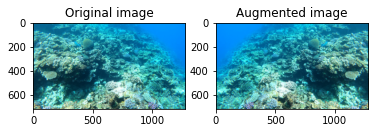

In [ ]:
visualize(image, new_image)

In [ ]:
def preprocess_data(image, norm_box, img_idx):
  "Preprocessing a single image"
  new_image , new_bbox = random_flip_images(image, norm_box[img_idx])
  return new_image, new_bbox

In [ ]:
# def preprocess_data(path, norm_box):
#   augmented_images = "/content/aug_imgs"                    # folder path to store augmented images
#   augmented_bboxes = {key:[] for key in norm_box.keys()}  # augmented bounding boxes
#   count = 0
#   for image in os.listdir(path):
#     count = count+1
#     print(count,image.split(".")[0])
#     img_idx = int(image.split(".")[0])
#     image = img.imread(os.path.join(path,image))
#     new_image , new_bbox = random_flip_images(image, norm_box[img_idx])
#     augmented_bboxes[img_idx].append(new_bbox)
#     tf.keras.preprocessing.image.save_img(path=os.path.join(augmented_images,f"{img_idx}.jpg"), x=asarray(new_image), file_format="jpeg")
#   return augmented_bboxes

# Generating Anchor boxes

In [ ]:
class AnchorBox:
  def __init__(self):
    self.aspect_ratios = [0.5, 1.0, 2.0]
    self.scales = [2**x for x in [0, 1/3, 2/3]]

    self._num_anchors = len(self.aspect_ratios)*len(self.scales)
    self._strides = [2**i for i in range(3,8)]
    self._areas = [x**2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
    self._anchor_dims = self._compute_dims()

  def _compute_dims(self):
    anchor_dims_all = []
    for area in self._areas:
      anchor_dims = []
      for ratio in self.aspect_ratios:
        anchor_height = tf.math.sqrt(area / ratio)
        anchor_width = area / anchor_height
        dims = tf.reshape(
            tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
            )
        for scale in self.scales:
          anchor_dims.append(scale * dims)
      anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
      
    return anchor_dims_all
  
  def _get_anchors(self, feature_height, feature_width, level):
    rx = tf.range(feature_width, dtype=tf.float32) + 0.5
    ry = tf.range(feature_height, dtype=tf.float32) + 0.5
    centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
    centers = tf.expand_dims(centers, axis=-2)
    centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
    dims = tf.tile(
        self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
    anchors = tf.concat([centers, dims], axis=-1)
    return tf.reshape(
        anchors, [feature_height * feature_width * self._num_anchors, 4])

  def get_anchors(self, image_height, image_width):
    anchors = [
               self._get_anchors(
                  tf.math.ceil(image_height / 2 ** i),
                  tf.math.ceil(image_width / 2 ** i),
                  i,
                  )
               for i in range(3, 8)
               ]
    return tf.concat(anchors, axis=0)

In [ ]:
class Encoder:
  def __init__(self):
    self._anchor_box = AnchorBox()
    self._box_variance = tf.convert_to_tensor(
        [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )
    
  def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
    iou_matrix = compute_iou(anchor_boxes, gt_boxes)
    max_iou = tf.reduce_max(iou_matrix, axis=1)
    matched_gt_idx = tf.argmax(iou_matrix, axis=1)
    positive_mask = tf.greater_equal(max_iou, match_iou)
    negative_mask = tf.less(max_iou, ignore_iou)
    ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
    return (
        matched_gt_idx,
        tf.cast(positive_mask, dtype=tf.float32),
        tf.cast(ignore_mask, dtype=tf.float32),
        )
    
  def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
    box_target = tf.concat(
        [
         (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
         tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
         ], axis=-1,
         )
    box_target = box_target / self._box_variance
    return box_target
  
  def _encode_sample(self, image_shape, gt_boxes, cls_ids):
    anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
    cls_ids = tf.cast(cls_ids, dtype=tf.float32)
    matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(anchor_boxes, gt_boxes)
    matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
    box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
    cls_target = tf.where(
        tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
    cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
    cls_target = tf.expand_dims(cls_target, axis=-1)
    label = tf.concat([box_target, cls_target], axis=-1)
    return label

  def encode_batch(self, batch_images, gt_boxes, cls_ids):
    images_shape = tf.shape(batch_images)
    batch_size = images_shape[0]

    labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
    for i in range(batch_size):
      label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
      labels = labels.write(i, label)
    batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
    return batch_images, labels.stack()

In [ ]:
def get_backbone():
  backbone = keras.applications.ResNet50(
      include_top=False, input_shape=[None, None, 3]
      )
  c3_output, c4_output, c5_output = [
                                     backbone.get_layer(layer_name).output
                                     for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
                                     ]
  return keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])

In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):
  def __init__(self, backbone=None, **kwargs):
    super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
    self.backbone = backbone if backbone else get_backbone()
    self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
    self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
    self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
    self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
    self.upsample_2x = tf.keras.layers.UpSampling2D(2)

  def call(self, images, training=False):
    c3_output, c4_output, c5_output = self.backbone(images, training=training)
    p3_output = self.conv_c3_1x1(c3_output)
    p4_output = self.conv_c4_1x1(c4_output)
    p5_output = self.conv_c5_1x1(c5_output)
    p4_output = p4_output + self.upsample_2x(p5_output)
    p3_output = p3_output + self.upsample_2x(p4_output)
    p3_output = self.conv_c3_3x3(p3_output)
    p4_output = self.conv_c4_3x3(p4_output)
    p5_output = self.conv_c5_3x3(p5_output)
    p6_output = self.conv_c6_3x3(c5_output)
    p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
    return p3_output, p4_output, p5_output, p6_output, p7_output